## Image classification with CNN

In [1]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# import albumentations as A
#from autoaugment import CIFAR10Policy

Device Configuration

In [2]:
# CUDA for PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda
NVIDIA GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
# Hyper-parameters 
num_epochs = 5
batch_size = 64
learning_rate = 0.01

## Step1_Data for our image classification 🔄

In [4]:
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.002, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [5]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),transforms.ToTensor()
     ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([3, 274, 274])


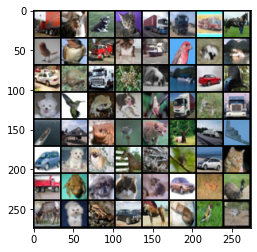

truck cat   dog   cat   truck truck truck horse bird  bird  truck dog   truck bird  cat   ship  car   frog  truck frog  dog   ship  car   bird  dog   bird  frog  dog   frog  truck frog  truck ship  plane frog  bird  cat   deer  truck plane car   dog   dog   horse frog  bird  car   cat   truck frog  dog   cat   cat   car   deer  bird  deer  dog   frog  car   horse cat   bird  bird 


In [6]:
## just for visualisation
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    print(img.shape)
    img = img    # unnormalize
    npimg = img.numpy()
    #print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Step2_Network architecture 🤖

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) #output layer
        
        return x

## Step3_Model ingredients

In [8]:
net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Step5_Model Training - forward, backward, weight updates

In [9]:
def train(model, train_loader, val_loader=None,  epochs = 15, save = False):
    for epoch in range(epochs): 
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        net.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in testloader:
                    inputs, labels = data
                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(net.state_dict(), "save_"+str(epoch)+".pth")

In [10]:
train(net, trainloader, testloader,  save=False)

[Epoch: 1, Batch:   10 /  782], loss: 2.308
[Epoch: 1, Batch:   20 /  782], loss: 2.301
[Epoch: 1, Batch:   30 /  782], loss: 2.305
[Epoch: 1, Batch:   40 /  782], loss: 2.306
[Epoch: 1, Batch:   50 /  782], loss: 2.303
[Epoch: 1, Batch:   60 /  782], loss: 2.303
[Epoch: 1, Batch:   70 /  782], loss: 2.303
[Epoch: 1, Batch:   80 /  782], loss: 2.304
[Epoch: 1, Batch:   90 /  782], loss: 2.306
[Epoch: 1, Batch:  100 /  782], loss: 2.305
[Epoch: 1, Batch:  110 /  782], loss: 2.301
[Epoch: 1, Batch:  120 /  782], loss: 2.302
[Epoch: 1, Batch:  130 /  782], loss: 2.301
[Epoch: 1, Batch:  140 /  782], loss: 2.302
[Epoch: 1, Batch:  150 /  782], loss: 2.303
[Epoch: 1, Batch:  160 /  782], loss: 2.302
[Epoch: 1, Batch:  170 /  782], loss: 2.304
[Epoch: 1, Batch:  180 /  782], loss: 2.302
[Epoch: 1, Batch:  190 /  782], loss: 2.304
[Epoch: 1, Batch:  200 /  782], loss: 2.303
[Epoch: 1, Batch:  210 /  782], loss: 2.302
[Epoch: 1, Batch:  220 /  782], loss: 2.303
[Epoch: 1, Batch:  230 /  782], 

[Epoch: 3, Batch:  310 /  782], loss: 1.633
[Epoch: 3, Batch:  320 /  782], loss: 1.601
[Epoch: 3, Batch:  330 /  782], loss: 1.635
[Epoch: 3, Batch:  340 /  782], loss: 1.570
[Epoch: 3, Batch:  350 /  782], loss: 1.666
[Epoch: 3, Batch:  360 /  782], loss: 1.655
[Epoch: 3, Batch:  370 /  782], loss: 1.662
[Epoch: 3, Batch:  380 /  782], loss: 1.658
[Epoch: 3, Batch:  390 /  782], loss: 1.536
[Epoch: 3, Batch:  400 /  782], loss: 1.513
[Epoch: 3, Batch:  410 /  782], loss: 1.499
[Epoch: 3, Batch:  420 /  782], loss: 1.484
[Epoch: 3, Batch:  430 /  782], loss: 1.534
[Epoch: 3, Batch:  440 /  782], loss: 1.482
[Epoch: 3, Batch:  450 /  782], loss: 1.506
[Epoch: 3, Batch:  460 /  782], loss: 1.574
[Epoch: 3, Batch:  470 /  782], loss: 1.605
[Epoch: 3, Batch:  480 /  782], loss: 1.538
[Epoch: 3, Batch:  490 /  782], loss: 1.516
[Epoch: 3, Batch:  500 /  782], loss: 1.535
[Epoch: 3, Batch:  510 /  782], loss: 1.584
[Epoch: 3, Batch:  520 /  782], loss: 1.561
[Epoch: 3, Batch:  530 /  782], 

[Epoch: 5, Batch:  610 /  782], loss: 1.116
[Epoch: 5, Batch:  620 /  782], loss: 1.141
[Epoch: 5, Batch:  630 /  782], loss: 1.079
[Epoch: 5, Batch:  640 /  782], loss: 1.100
[Epoch: 5, Batch:  650 /  782], loss: 1.166
[Epoch: 5, Batch:  660 /  782], loss: 1.126
[Epoch: 5, Batch:  670 /  782], loss: 1.103
[Epoch: 5, Batch:  680 /  782], loss: 1.121
[Epoch: 5, Batch:  690 /  782], loss: 1.116
[Epoch: 5, Batch:  700 /  782], loss: 1.095
[Epoch: 5, Batch:  710 /  782], loss: 1.145
[Epoch: 5, Batch:  720 /  782], loss: 1.206
[Epoch: 5, Batch:  730 /  782], loss: 1.154
[Epoch: 5, Batch:  740 /  782], loss: 1.125
[Epoch: 5, Batch:  750 /  782], loss: 1.115
[Epoch: 5, Batch:  760 /  782], loss: 1.093
[Epoch: 5, Batch:  770 /  782], loss: 1.141
[Epoch: 5, Batch:  780 /  782], loss: 1.108
Valid accuracy: 58 %
[Epoch: 6, Batch:   10 /  782], loss: 1.215
[Epoch: 6, Batch:   20 /  782], loss: 1.061
[Epoch: 6, Batch:   30 /  782], loss: 1.093
[Epoch: 6, Batch:   40 /  782], loss: 1.122
[Epoch: 6, 

[Epoch: 8, Batch:  120 /  782], loss: 0.854
[Epoch: 8, Batch:  130 /  782], loss: 0.883
[Epoch: 8, Batch:  140 /  782], loss: 0.919
[Epoch: 8, Batch:  150 /  782], loss: 0.864
[Epoch: 8, Batch:  160 /  782], loss: 0.849
[Epoch: 8, Batch:  170 /  782], loss: 0.891
[Epoch: 8, Batch:  180 /  782], loss: 0.858
[Epoch: 8, Batch:  190 /  782], loss: 0.935
[Epoch: 8, Batch:  200 /  782], loss: 0.931
[Epoch: 8, Batch:  210 /  782], loss: 0.930
[Epoch: 8, Batch:  220 /  782], loss: 0.924
[Epoch: 8, Batch:  230 /  782], loss: 0.921
[Epoch: 8, Batch:  240 /  782], loss: 0.898
[Epoch: 8, Batch:  250 /  782], loss: 0.802
[Epoch: 8, Batch:  260 /  782], loss: 0.933
[Epoch: 8, Batch:  270 /  782], loss: 0.874
[Epoch: 8, Batch:  280 /  782], loss: 0.907
[Epoch: 8, Batch:  290 /  782], loss: 0.830
[Epoch: 8, Batch:  300 /  782], loss: 0.925
[Epoch: 8, Batch:  310 /  782], loss: 0.966
[Epoch: 8, Batch:  320 /  782], loss: 0.929
[Epoch: 8, Batch:  330 /  782], loss: 0.917
[Epoch: 8, Batch:  340 /  782], 

[Epoch: 10, Batch:  410 /  782], loss: 0.771
[Epoch: 10, Batch:  420 /  782], loss: 0.754
[Epoch: 10, Batch:  430 /  782], loss: 0.760
[Epoch: 10, Batch:  440 /  782], loss: 0.876
[Epoch: 10, Batch:  450 /  782], loss: 0.746
[Epoch: 10, Batch:  460 /  782], loss: 0.799
[Epoch: 10, Batch:  470 /  782], loss: 0.782
[Epoch: 10, Batch:  480 /  782], loss: 0.723
[Epoch: 10, Batch:  490 /  782], loss: 0.745
[Epoch: 10, Batch:  500 /  782], loss: 0.804
[Epoch: 10, Batch:  510 /  782], loss: 0.787
[Epoch: 10, Batch:  520 /  782], loss: 0.729
[Epoch: 10, Batch:  530 /  782], loss: 0.835
[Epoch: 10, Batch:  540 /  782], loss: 0.714
[Epoch: 10, Batch:  550 /  782], loss: 0.720
[Epoch: 10, Batch:  560 /  782], loss: 0.721
[Epoch: 10, Batch:  570 /  782], loss: 0.726
[Epoch: 10, Batch:  580 /  782], loss: 0.749
[Epoch: 10, Batch:  590 /  782], loss: 0.702
[Epoch: 10, Batch:  600 /  782], loss: 0.808
[Epoch: 10, Batch:  610 /  782], loss: 0.751
[Epoch: 10, Batch:  620 /  782], loss: 0.695
[Epoch: 10

[Epoch: 12, Batch:  670 /  782], loss: 0.673
[Epoch: 12, Batch:  680 /  782], loss: 0.657
[Epoch: 12, Batch:  690 /  782], loss: 0.766
[Epoch: 12, Batch:  700 /  782], loss: 0.697
[Epoch: 12, Batch:  710 /  782], loss: 0.604
[Epoch: 12, Batch:  720 /  782], loss: 0.728
[Epoch: 12, Batch:  730 /  782], loss: 0.671
[Epoch: 12, Batch:  740 /  782], loss: 0.661
[Epoch: 12, Batch:  750 /  782], loss: 0.692
[Epoch: 12, Batch:  760 /  782], loss: 0.770
[Epoch: 12, Batch:  770 /  782], loss: 0.731
[Epoch: 12, Batch:  780 /  782], loss: 0.801
Valid accuracy: 72 %
[Epoch: 13, Batch:   10 /  782], loss: 0.666
[Epoch: 13, Batch:   20 /  782], loss: 0.657
[Epoch: 13, Batch:   30 /  782], loss: 0.561
[Epoch: 13, Batch:   40 /  782], loss: 0.591
[Epoch: 13, Batch:   50 /  782], loss: 0.649
[Epoch: 13, Batch:   60 /  782], loss: 0.562
[Epoch: 13, Batch:   70 /  782], loss: 0.532
[Epoch: 13, Batch:   80 /  782], loss: 0.626
[Epoch: 13, Batch:   90 /  782], loss: 0.545
[Epoch: 13, Batch:  100 /  782], l

[Epoch: 15, Batch:  140 /  782], loss: 0.577
[Epoch: 15, Batch:  150 /  782], loss: 0.602
[Epoch: 15, Batch:  160 /  782], loss: 0.639
[Epoch: 15, Batch:  170 /  782], loss: 0.521
[Epoch: 15, Batch:  180 /  782], loss: 0.582
[Epoch: 15, Batch:  190 /  782], loss: 0.549
[Epoch: 15, Batch:  200 /  782], loss: 0.514
[Epoch: 15, Batch:  210 /  782], loss: 0.578
[Epoch: 15, Batch:  220 /  782], loss: 0.580
[Epoch: 15, Batch:  230 /  782], loss: 0.522
[Epoch: 15, Batch:  240 /  782], loss: 0.652
[Epoch: 15, Batch:  250 /  782], loss: 0.562
[Epoch: 15, Batch:  260 /  782], loss: 0.604
[Epoch: 15, Batch:  270 /  782], loss: 0.624
[Epoch: 15, Batch:  280 /  782], loss: 0.534
[Epoch: 15, Batch:  290 /  782], loss: 0.540
[Epoch: 15, Batch:  300 /  782], loss: 0.603
[Epoch: 15, Batch:  310 /  782], loss: 0.610
[Epoch: 15, Batch:  320 /  782], loss: 0.611
[Epoch: 15, Batch:  330 /  782], loss: 0.540
[Epoch: 15, Batch:  340 /  782], loss: 0.528
[Epoch: 15, Batch:  350 /  782], loss: 0.663
[Epoch: 15

In [11]:
all_preds = []
all_labels = []
net.eval()

with torch.no_grad():
    for i, data in enumerate(testloader):
        print('Batch [%4d / %4d]' % (i+1, len(testloader)))
        inputs, labels = data
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

Batch [   1 /  157]
Batch [   2 /  157]
Batch [   3 /  157]
Batch [   4 /  157]
Batch [   5 /  157]
Batch [   6 /  157]
Batch [   7 /  157]
Batch [   8 /  157]
Batch [   9 /  157]
Batch [  10 /  157]
Batch [  11 /  157]
Batch [  12 /  157]
Batch [  13 /  157]
Batch [  14 /  157]
Batch [  15 /  157]
Batch [  16 /  157]
Batch [  17 /  157]
Batch [  18 /  157]
Batch [  19 /  157]
Batch [  20 /  157]
Batch [  21 /  157]
Batch [  22 /  157]
Batch [  23 /  157]
Batch [  24 /  157]
Batch [  25 /  157]
Batch [  26 /  157]
Batch [  27 /  157]
Batch [  28 /  157]
Batch [  29 /  157]
Batch [  30 /  157]
Batch [  31 /  157]
Batch [  32 /  157]
Batch [  33 /  157]
Batch [  34 /  157]
Batch [  35 /  157]
Batch [  36 /  157]
Batch [  37 /  157]
Batch [  38 /  157]
Batch [  39 /  157]
Batch [  40 /  157]
Batch [  41 /  157]
Batch [  42 /  157]
Batch [  43 /  157]
Batch [  44 /  157]
Batch [  45 /  157]
Batch [  46 /  157]
Batch [  47 /  157]
Batch [  48 /  157]
Batch [  49 /  157]
Batch [  50 /  157]


In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds);
cm

array([[748,  24,  72,   4,   9,   3,   6,   3, 105,  26],
       [ 19, 899,  12,   4,   4,   1,   4,   0,  36,  21],
       [ 40,   5, 784,  23,  37,  36,  39,  10,  20,   6],
       [ 33,  13, 161, 466,  40, 148,  67,  28,  34,  10],
       [ 25,   7, 142,  37, 639,  31,  59,  47,  12,   1],
       [ 20,   5, 131, 100,  40, 619,  31,  36,  12,   6],
       [  9,  10,  82,  48,  12,  14, 806,   2,  13,   4],
       [ 19,   9,  72,  28,  66,  59,   6, 721,   7,  13],
       [ 36,  23,  17,   2,   2,   4,   1,   7, 900,   8],
       [ 48, 158,  20,  11,   4,  11,   6,   8,  45, 689]], dtype=int64)

In [13]:
import itertools
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
# classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Normalized confusion matrix


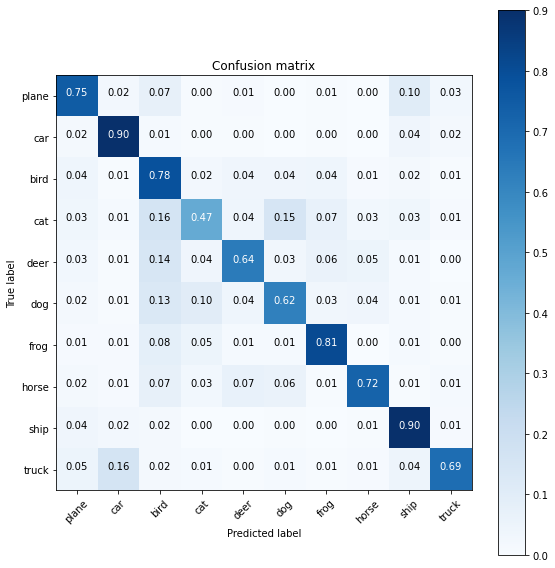

In [15]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes), normalize=True)